# Spike Sorting

### Declaring needed libraries and setting global windowSize

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
samplingRate = 24414
windowSize = 0.002 * samplingRate
windowSize = int(windowSize)

### Reading the given data and storing it in a dataframe
##### Each column is an electrode, electrode 1 is the first column, electrode 2 is the second

In [2]:
df = pd.read_csv("data.txt", delimiter='	')
df.columns = ['first','second']
first, second =  df['first'],df['second']

Lets take a look at first and second

In [3]:
first

0          7.370100e-06
1         -9.368400e-06
2         -1.659100e-05
3         -1.183000e-05
4         -1.696100e-06
               ...     
4417518    4.372900e-07
4417519    1.735100e-06
4417520   -6.696300e-07
4417521   -6.815500e-06
4417522   -9.699100e-06
Name: first, Length: 4417523, dtype: float64

In [4]:
second

0          0.000002
1          0.000005
2          0.000007
3          0.000006
4          0.000005
             ...   
4417518   -0.000003
4417519   -0.000004
4417520    0.000007
4417521    0.000017
4417522    0.000012
Name: second, Length: 4417523, dtype: float64

### Extracting the features of each electrode

the next part of the code is concerned with extracting features. This is done through finding the peaks of each spike, and next finding two features in the spikes: maximum difference between two consecutive samples and the standard deviation. To find the peaks we first multiply 3.5 by the standard deviation of the first 500 samples. Since we use dataframes we can simply splice the first 500 samples and use a built in STD function then multiply those by 3.5.  In order to find the window of a spike we multiply the sampling rate by the duration of a peak. Since sampling rate is the frequency and duration is in milliseconds, multiplying the two will give us a scalar which represents the window size of one spike. Next we need to align the spikes to do so, we loop over the dataframe, if a number is higher than the threshold we perform another loop to find the maximum value this is now the peak so we can make that the center of our “window”, which simply means we have to get windowsize / 2 on the right and windowsize / 2 on the left, and the peak in the center. Now that code ensures that spikes are aligned it remains to push these features into a dataframe while looping. To do so we simply store these features, (a long with the index of the peak)  into a list and once the loops are all finished we append into a features dataframe, the extra step of putting them into a list is done because appending into the dataframe right away will increase time complexity.


In [5]:
def extractFeatures(df,windowSize):
    featureList = []
    threshold = 3.5 * df[:499].std(axis=0)
    arr = df.to_numpy()
    i = 0
    while i < len(arr):
        if arr[i] > threshold:
            j = i
            maximum = arr[i]
            maxInd = i
            while(arr[j] > threshold):
                if arr[j] > maximum:
                    maximum = arr[j]
                    maxInd = j
                j+=1
                
            start = int(max(0, maxInd - windowSize // 2))
            end = int(min(len(arr), maxInd + windowSize // 2))
            
            window = arr[int(start):int(end)]
            std = np.std(window)
            diff = np.max(np.abs(np.diff(window)))
            mean =  np.mean(window)
            
            featureList.append({'std': std, 'diff': diff,'peakIndex' : maxInd, 'timeStamp': maxInd/samplingRate, 'spike_mean': mean })
            i = end
        else:
            i += 1
    featuresDF = pd.DataFrame(featureList)
    return featuresDF

Lets take a look at features

In [6]:
features1 = extractFeatures(first, windowSize)
features1

,std,diff,peakIndex,timeStamp,spike_mean
0,0.000015,0.000028,745,0.030515,-1.249838e-06
1,0.000011,0.000019,1226,0.050217,-3.244973e-07
2,0.000025,0.000054,1793,0.073441,-2.176583e-06
3,0.000014,0.000016,2025,0.082944,-2.191047e-06
4,0.000015,0.000018,3236,0.132547,-1.705252e-07
...,...,...,...,...,...
4518,0.000011,0.000023,4416143,180.885680,1.059440e-06
4519,0.000020,0.000048,4416708,180.908823,-8.687546e-07
4520,0.000014,0.000017,4416735,180.909929,-1.791596e-07
4521,0.000024,0.000051,4416937,180.918203,-4.723875e-07


In [7]:
features2 = extractFeatures(second, windowSize)
features2

,std,diff,peakIndex,timeStamp,spike_mean
0,0.000018,0.000030,1814,0.074302,1.218531e-06
1,0.000012,0.000011,2837,0.116204,-6.432123e-08
2,0.000019,0.000034,3542,0.145081,6.774875e-07
3,0.000022,0.000030,4385,0.179610,-3.649529e-06
4,0.000021,0.000034,4414,0.180798,-1.033488e-06
...,...,...,...,...,...
2040,0.000015,0.000012,4404890,180.424756,-1.968342e-06
2041,0.000010,0.000012,4409131,180.598468,1.123941e-06
2042,0.000010,0.000012,4413009,180.757311,1.245129e-06
2043,0.000011,0.000015,4413334,180.770623,1.030670e-06


### Plotting the extracted features of each electrode spike

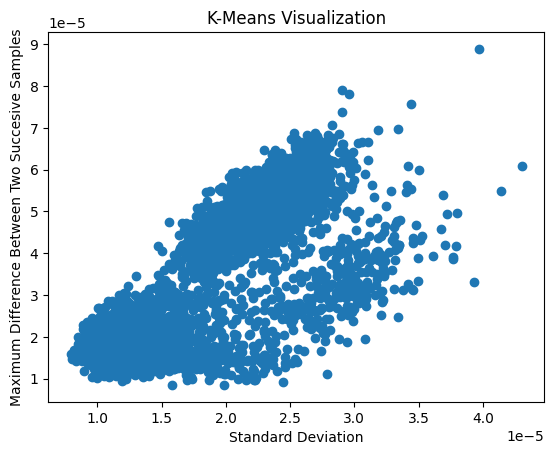

In [8]:
plt.scatter(features1['std'], features1['diff'])
plt.xlabel('Standard Deviation')
plt.ylabel('Maximum Difference Between Two Succesive Samples')
plt.title('K-Means Visualization')
plt.show()

By visual inspection of the above plotted features, we can identify 3 clusters for electrode 1.

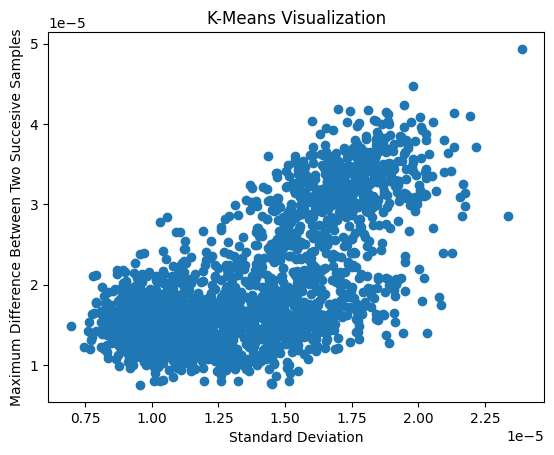

In [9]:
plt.scatter(features2['std'], features2['diff'])
plt.xlabel('Standard Deviation')
plt.ylabel('Maximum Difference Between Two Succesive Samples')
plt.title('K-Means Visualization')
plt.show()

By visual inspection of the above plotted features, we can identify 3 clusters for electrode 2.

By inspecting these 3 main clusters it is realized through three layers. The top section with a strong concentration of points. A middle section with some spread and a bottom section again with a lot of concentration of points. Next we need to use K-Means Clustering while setting the number of clusters to three. After that for consistency purposes we calculate the mean of each cluster and sort them in order. For example, the bottom section will always be neuron one regardless of whether we run on column one or column two. Then we store this as a new column in the features dataframe for future use.

### Identifying the clusters programatically

In [10]:
def addCluster(features):
    X = features[['diff', 'std']]
    kmeans = KMeans(n_clusters=3)
    features['cluster'] = kmeans.fit_predict(X)
    #the below will make sure the neuron cluster is always consitent ie neuron 0 wont be top in first but bottom in second
    clusterMean = features.groupby('cluster').mean().sort_values('diff')['diff'].index
    mapCluster = {cluster: i for i, cluster in enumerate(clusterMean)}
    features['cluster'] = features['cluster'].map(mapCluster)
    
    return features

Lets take a look at the updated features dataframe

In [11]:
features1 = addCluster(features1)
features2 = addCluster(features2)
features1

,std,diff,peakIndex,timeStamp,spike_mean,cluster
0,0.000015,0.000028,745,0.030515,-1.249838e-06,0
1,0.000011,0.000019,1226,0.050217,-3.244973e-07,0
2,0.000025,0.000054,1793,0.073441,-2.176583e-06,2
3,0.000014,0.000016,2025,0.082944,-2.191047e-06,0
4,0.000015,0.000018,3236,0.132547,-1.705252e-07,0
...,...,...,...,...,...,...
4518,0.000011,0.000023,4416143,180.885680,1.059440e-06,0
4519,0.000020,0.000048,4416708,180.908823,-8.687546e-07,1
4520,0.000014,0.000017,4416735,180.909929,-1.791596e-07,0
4521,0.000024,0.000051,4416937,180.918203,-4.723875e-07,2


### Plotting the features after clustering

Finally we plot the clusters using colors which can be soon below (blue: neuron1, red: neuron2, yellow: neuron3)

In [12]:
def plotFeatures(features):
    plt.scatter(features['std'], features['diff'], c=features['cluster'], cmap='plasma')
    plt.xlabel('Standard Deviation')
    plt.ylabel('Maximum Difference Between Two Succesive Samples')
    plt.title('K-Means Visualization')
    plt.show()
    return features

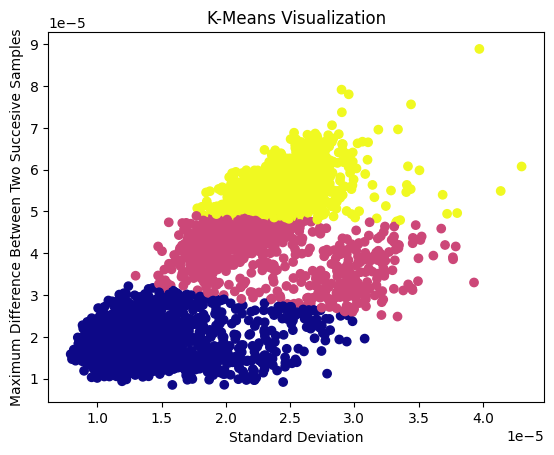

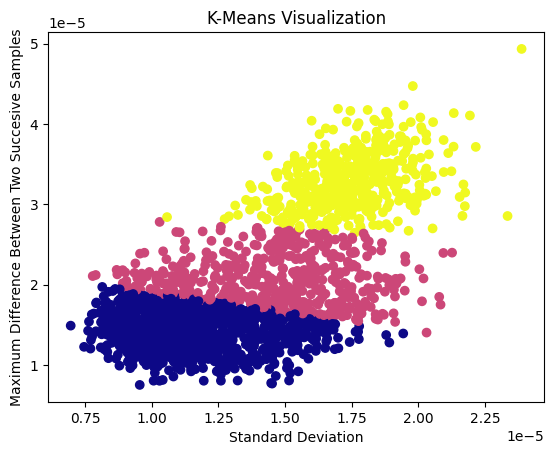

In [13]:
features1 = plotFeatures(features1)
features2 = plotFeatures(features2)

We can now tell which spike belongs to which neuron visually.

### Plotting the electrode signals, this time identifying the different neurons in which each spike belongs to

Using these values we can plot the signal while marking the peaks in different colors. First we make three vectors: one containing the peak indices, one containing the clusters, and then we use the numpy unique function to store the unique values of clusters (0,1,2 for neuron 1,2,3 respectively). Then we use bitwise logic to capture only the first 20000 samples (take the peaks with indices less than 20000 and the clusters less than 20000 samples in). Next we store these in a valid peaks and valid clusters vector. Next we clip the original signal to be the first 20000 values. Finally we plot these values by simply matching the valid peaks to their respective cluster and using a scatter plot. 

In [14]:
def plotSignal(Osignal,featuers):
    peaks = featuers['peakIndex'].values
    clusters = featuers['cluster'].values
    unique_clusters = np.unique(clusters)

    valid_indices = (peaks <= 20000) & (np.arange(len(clusters)) <= 20000)

    valid_peaks = peaks[valid_indices]
    valid_clusters = clusters[valid_indices]

    signal = Osignal.iloc[:20000].to_numpy()
    plt.plot(signal, label='Signal')

    cluster_colors = ['blue', 'red', 'yellow'] 
    for i, cluster in enumerate(unique_clusters):
      cluster_peaks = valid_peaks[valid_clusters == cluster]
      plt.scatter(cluster_peaks, signal[cluster_peaks], label=f'Cluster {cluster}', color=cluster_colors[i], marker='*')

    plt.title(f'Signal with Clustered Peaks (First {20000} samples)')
    plt.xlabel('Peak')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.show()


The plots for the first and second electrode respectively

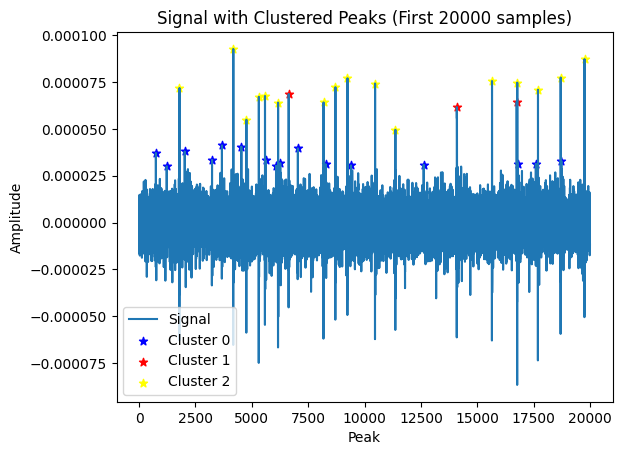

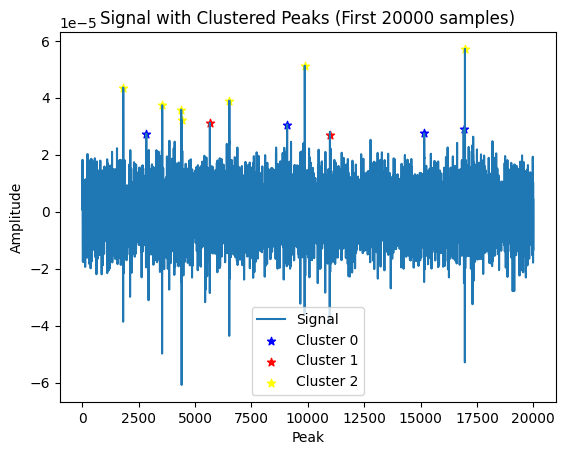

In [15]:
plotSignal(first, features1)
plotSignal(second, features2)

### Lastly we plot the average neuron spike for each neuron and for each electrode

Finally we plot the average neuron spike. To do so we loop over all the clusters and gather the values in the window, next we push them into a vector and calculate the average for the portion of the window. To finish we plot these averages for all the spikes.

In [16]:
def plotAverageNeurons(feauture, data):
    clusters = np.unique(feauture["cluster"])

    color = ["blue","red","black"]

    avg_spikes = []
    for cluster in clusters:
        allSpikes = []
        for ind in feauture[feauture["cluster"] == cluster]["peakIndex"]:
            start = ind - windowSize//2
            end = ind + windowSize//2
            allSpikes.append([data[start:end]])
        avg_spikes_curr = np.average(allSpikes, axis = 0)[0]
        avg_spikes.append(avg_spikes_curr)
    indices = np.arange(len(avg_spikes[0]))
    for cluster in clusters:
        plt.plot(indices, avg_spikes[cluster], color=color[cluster], label="neuron "+str(cluster+1))
    plt.xlabel('Spike Index')
    plt.ylabel('Amplitude')
    plt.title('Single Spike Waveform')
    plt.legend()

    plt.grid(True)
    plt.show()
    unique_values = feauture['cluster'].unique()
    value_mapping = {value: avg_spikes[index] for index, value in enumerate(unique_values)}
    feauture['cumu_avg'] = feauture['cluster'].map(value_mapping)
    return avg_spikes

Plotting below

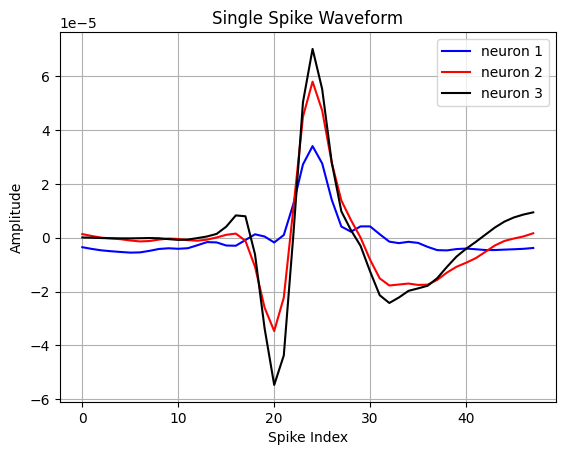

[array([-3.51769697e-06, -4.16504340e-06, -4.68935809e-06, -5.01597509e-06,
        -5.29328327e-06, -5.53044009e-06, -5.44992507e-06, -4.87520429e-06,
        -4.16583715e-06, -3.91855388e-06, -4.10507711e-06, -3.89770517e-06,
        -2.78780690e-06, -1.62171422e-06, -1.74074158e-06, -2.89322396e-06,
        -2.97732162e-06, -8.61586656e-07,  1.27199541e-06,  4.50477676e-07,
        -1.76850684e-06,  1.00412770e-06,  1.25272518e-05,  2.72239536e-05,
         3.40003037e-05,  2.75807793e-05,  1.40751267e-05,  4.14715926e-06,
         2.24586629e-06,  4.20633536e-06,  4.20277218e-06,  1.29340402e-06,
        -1.45550504e-06, -2.01248601e-06, -1.51374411e-06, -1.92536467e-06,
        -3.40385452e-06, -4.60602386e-06, -4.70548954e-06, -4.21654504e-06,
        -4.01720247e-06, -4.27801078e-06, -4.56430854e-06, -4.57465595e-06,
        -4.41843720e-06, -4.27772038e-06, -4.11299203e-06, -3.80995857e-06]),
 array([ 1.35408855e-06,  6.27973758e-07,  2.34581182e-08, -2.64150911e-07,
        -5

In [17]:
avg_spike_1 = plotAverageNeurons(features1, first)
avg_spike_1

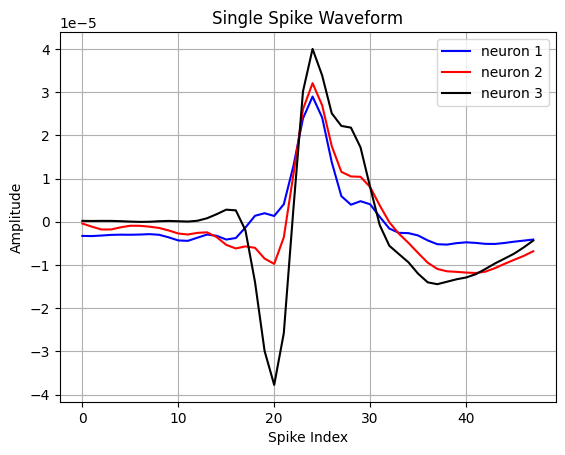

[array([-3.28211174e-06, -3.32147885e-06, -3.19617429e-06, -3.04606480e-06,
        -2.99702648e-06, -3.01595278e-06, -2.96956424e-06, -2.87649530e-06,
        -3.01988869e-06, -3.61432748e-06, -4.32753568e-06, -4.42730088e-06,
        -3.69294375e-06, -2.97033846e-06, -3.25651735e-06, -4.12382953e-06,
        -3.77459862e-06, -1.34676897e-06,  1.37735212e-06,  1.96626314e-06,
         1.33482780e-06,  4.04080117e-06,  1.28849251e-05,  2.39042297e-05,
         2.89729335e-05,  2.41112252e-05,  1.37756720e-05,  5.92286610e-06,
         3.93731579e-06,  4.75339612e-06,  4.03495412e-06,  1.14240228e-06,
        -1.57741524e-06, -2.57476578e-06, -2.64394713e-06, -3.18267076e-06,
        -4.32458845e-06, -5.20063749e-06, -5.29901671e-06, -4.96180819e-06,
        -4.76904640e-06, -4.90046701e-06, -5.12188409e-06, -5.14559165e-06,
        -4.92067532e-06, -4.62002581e-06, -4.37713527e-06, -4.12623979e-06]),
 array([-4.18685731e-07, -1.14919726e-06, -1.79791578e-06, -1.78872952e-06,
        -1

In [18]:
avg_spike_2 = plotAverageNeurons(features2, second)
avg_spike_2

creating a custom function to split dataframe according to neuron and saving in its own dataframe

In [19]:
def getNeuronFeatures(features, cluster):
    return features[features["cluster"] == cluster].reset_index(drop=True).drop("cluster", axis=1)

Saving and examples can be shown below

In [20]:
neuron1_1 = getNeuronFeatures(features1, 0)
neuron1_1

,std,diff,peakIndex,timeStamp,spike_mean,cumu_avg
0,0.000015,0.000028,745,0.030515,-1.249838e-06,"[-3.5176969727741363e-06, -4.1650433955014095e..."
1,0.000011,0.000019,1226,0.050217,-3.244973e-07,"[-3.5176969727741363e-06, -4.1650433955014095e..."
2,0.000014,0.000016,2025,0.082944,-2.191047e-06,"[-3.5176969727741363e-06, -4.1650433955014095e..."
3,0.000015,0.000018,3236,0.132547,-1.705252e-07,"[-3.5176969727741363e-06, -4.1650433955014095e..."
4,0.000014,0.000030,3675,0.150528,-1.180960e-06,"[-3.5176969727741363e-06, -4.1650433955014095e..."
...,...,...,...,...,...,...
2129,0.000010,0.000027,4410006,180.634308,-1.772796e-06,"[-3.5176969727741363e-06, -4.1650433955014095e..."
2130,0.000014,0.000020,4410057,180.636397,2.889629e-06,"[-3.5176969727741363e-06, -4.1650433955014095e..."
2131,0.000011,0.000023,4416143,180.885680,1.059440e-06,"[-3.5176969727741363e-06, -4.1650433955014095e..."
2132,0.000014,0.000017,4416735,180.909929,-1.791596e-07,"[-3.5176969727741363e-06, -4.1650433955014095e..."


In [21]:
neuron2_1 = getNeuronFeatures(features1, 1)
neuron2_1

,std,diff,peakIndex,timeStamp,spike_mean,cumu_avg
0,0.000021,0.000045,6636,0.271811,-8.674225e-07,"[9.002032835606632e-08, -4.20340983488864e-09,..."
1,0.000030,0.000042,14094,0.577292,-2.583666e-06,"[9.002032835606632e-08, -4.20340983488864e-09,..."
2,0.000032,0.000029,16748,0.686000,-7.061023e-06,"[9.002032835606632e-08, -4.20340983488864e-09,..."
3,0.000018,0.000041,43311,1.774023,-2.759425e-06,"[9.002032835606632e-08, -4.20340983488864e-09,..."
4,0.000026,0.000029,68389,2.801221,-4.738516e-06,"[9.002032835606632e-08, -4.20340983488864e-09,..."
...,...,...,...,...,...,...
991,0.000021,0.000043,4408450,180.570574,-1.997719e-06,"[9.002032835606632e-08, -4.20340983488864e-09,..."
992,0.000017,0.000034,4408633,180.578070,-9.409150e-07,"[9.002032835606632e-08, -4.20340983488864e-09,..."
993,0.000019,0.000034,4409410,180.609896,-8.546242e-07,"[9.002032835606632e-08, -4.20340983488864e-09,..."
994,0.000022,0.000048,4409875,180.628942,-1.295352e-06,"[9.002032835606632e-08, -4.20340983488864e-09,..."


In [22]:
neuron3_1 = getNeuronFeatures(features1, 2)
neuron3_1

,std,diff,peakIndex,timeStamp,spike_mean,cumu_avg
0,0.000025,0.000054,1793,0.073441,-2.176583e-06,"[1.3540885481927727e-06, 6.279737580321296e-07..."
1,0.000029,0.000066,4180,0.171213,-1.452475e-06,"[1.3540885481927727e-06, 6.279737580321296e-07..."
2,0.000020,0.000051,4761,0.195011,2.728917e-08,"[1.3540885481927727e-06, 6.279737580321296e-07..."
3,0.000023,0.000057,5312,0.217580,-1.715601e-06,"[1.3540885481927727e-06, 6.279737580321296e-07..."
4,0.000023,0.000053,5585,0.228762,-1.268429e-06,"[1.3540885481927727e-06, 6.279737580321296e-07..."
...,...,...,...,...,...,...
1388,0.000025,0.000048,4406171,180.477226,-9.384825e-07,"[1.3540885481927727e-06, 6.279737580321296e-07..."
1389,0.000021,0.000058,4409385,180.608872,-7.357092e-07,"[1.3540885481927727e-06, 6.279737580321296e-07..."
1390,0.000022,0.000050,4412558,180.738838,-2.017169e-07,"[1.3540885481927727e-06, 6.279737580321296e-07..."
1391,0.000024,0.000052,4414290,180.809781,-5.376433e-07,"[1.3540885481927727e-06, 6.279737580321296e-07..."


In [23]:
neuron1_2 = getNeuronFeatures(features2, 0)
neuron1_2

,std,diff,peakIndex,timeStamp,spike_mean,cumu_avg
0,0.000012,0.000011,2837,0.116204,-6.432123e-08,"[-4.186857310924372e-07, -1.149197262605042e-0..."
1,0.000010,0.000015,9083,0.372041,4.010717e-07,"[-4.186857310924372e-07, -1.149197262605042e-0..."
2,0.000011,0.000018,15163,0.621078,9.805181e-07,"[-4.186857310924372e-07, -1.149197262605042e-0..."
3,0.000013,0.000015,16913,0.692758,-9.543383e-07,"[-4.186857310924372e-07, -1.149197262605042e-0..."
4,0.000009,0.000016,21970,0.899894,8.028479e-07,"[-4.186857310924372e-07, -1.149197262605042e-0..."
...,...,...,...,...,...,...
1092,0.000009,0.000018,4403622,180.372819,3.121594e-07,"[-4.186857310924372e-07, -1.149197262605042e-0..."
1093,0.000015,0.000012,4404890,180.424756,-1.968342e-06,"[-4.186857310924372e-07, -1.149197262605042e-0..."
1094,0.000010,0.000012,4409131,180.598468,1.123941e-06,"[-4.186857310924372e-07, -1.149197262605042e-0..."
1095,0.000010,0.000012,4413009,180.757311,1.245129e-06,"[-4.186857310924372e-07, -1.149197262605042e-0..."


In [24]:
neuron2_2 = getNeuronFeatures(features2, 1)
neuron2_2

,std,diff,peakIndex,timeStamp,spike_mean,cumu_avg
0,0.000010,0.000028,5657,0.231711,-6.884908e-07,"[1.9633095423728808e-07, 1.7073663983050857e-0..."
1,0.000015,0.000025,10978,0.449660,-8.861215e-07,"[1.9633095423728808e-07, 1.7073663983050857e-0..."
2,0.000015,0.000024,24081,0.986360,-1.655167e-06,"[1.9633095423728808e-07, 1.7073663983050857e-0..."
3,0.000012,0.000019,30971,1.268575,2.100266e-06,"[1.9633095423728808e-07, 1.7073663983050857e-0..."
4,0.000016,0.000023,64075,2.624519,-1.971738e-06,"[1.9633095423728808e-07, 1.7073663983050857e-0..."
...,...,...,...,...,...,...
471,0.000014,0.000019,4366930,178.869911,-8.494915e-07,"[1.9633095423728808e-07, 1.7073663983050857e-0..."
472,0.000019,0.000020,4370775,179.027402,-1.733107e-06,"[1.9633095423728808e-07, 1.7073663983050857e-0..."
473,0.000010,0.000021,4373748,179.149177,-2.322019e-07,"[1.9633095423728808e-07, 1.7073663983050857e-0..."
474,0.000013,0.000018,4403479,180.366962,-8.996894e-07,"[1.9633095423728808e-07, 1.7073663983050857e-0..."


In [25]:
neuron3_2 = getNeuronFeatures(features2, 2)
neuron3_2

,std,diff,peakIndex,timeStamp,spike_mean,cumu_avg
0,0.000018,0.000030,1814,0.074302,1.218531e-06,"[-3.2821117351868764e-06, -3.321478850957152e-..."
1,0.000019,0.000034,3542,0.145081,6.774875e-07,"[-3.2821117351868764e-06, -3.321478850957152e-..."
2,0.000022,0.000030,4385,0.179610,-3.649529e-06,"[-3.2821117351868764e-06, -3.321478850957152e-..."
3,0.000021,0.000034,4414,0.180798,-1.033488e-06,"[-3.2821117351868764e-06, -3.321478850957152e-..."
4,0.000017,0.000033,6520,0.267060,-1.870716e-06,"[-3.2821117351868764e-06, -3.321478850957152e-..."
...,...,...,...,...,...,...
467,0.000014,0.000032,4304720,176.321783,-1.319205e-06,"[-3.2821117351868764e-06, -3.321478850957152e-..."
468,0.000015,0.000034,4345238,177.981404,-2.814953e-06,"[-3.2821117351868764e-06, -3.321478850957152e-..."
469,0.000016,0.000031,4397511,180.122512,-1.807216e-06,"[-3.2821117351868764e-06, -3.321478850957152e-..."
470,0.000017,0.000032,4400415,180.241460,-1.623352e-06,"[-3.2821117351868764e-06, -3.321478850957152e-..."


### A function that captures all the required returns is below. For graphs check above.

In [26]:
def returnAll():
    samplingRate = 24414
    windowSize = 0.002 * samplingRate
    windowSize = int(windowSize)
    df = pd.read_csv("data.txt", delimiter='	')
    df.columns = ['first','second']
    first, second =  df['first'],df['second']
    features1 = extractFeatures(first, windowSize)
    features2 = extractFeatures(second, windowSize)
    features1 = addCluster(features1)
    features2 = addCluster(features2)
    plotAverageNeurons(features1, first)
    plotAverageNeurons(features2, second)
    neuron1_1 = getNeuronFeatures(features1, 0)
    neuron2_1 = getNeuronFeatures(features1, 1)
    neuron3_1 = getNeuronFeatures(features1, 2)
    neuron1_2 = getNeuronFeatures(features2, 0)
    neuron2_2 = getNeuronFeatures(features2, 1)
    neuron3_2 = getNeuronFeatures(features2, 2)
    return neuron1_1,neuron2_1,neuron3_1,neuron1_2,neuron2_2,neuron3_2

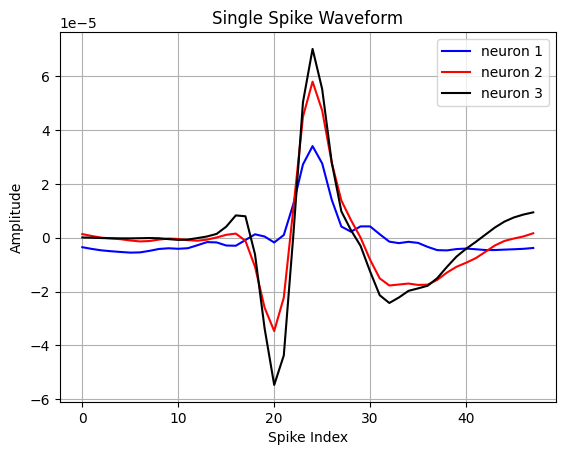

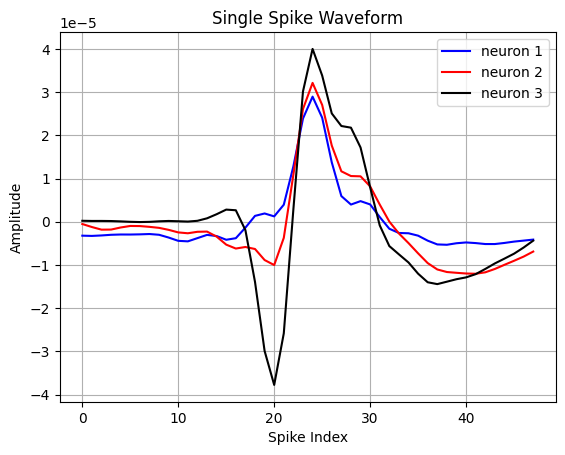

In [27]:
neuron1_1,neuron2_1,neuron3_1,neuron1_2,neuron2_2, neuron3_2 =  returnAll()

In [28]:
neuron1_1

,std,diff,peakIndex,timeStamp,spike_mean,cumu_avg
0,0.000015,0.000028,745,0.030515,-1.249838e-06,"[-3.5176969727741363e-06, -4.1650433955014095e..."
1,0.000011,0.000019,1226,0.050217,-3.244973e-07,"[-3.5176969727741363e-06, -4.1650433955014095e..."
2,0.000014,0.000016,2025,0.082944,-2.191047e-06,"[-3.5176969727741363e-06, -4.1650433955014095e..."
3,0.000015,0.000018,3236,0.132547,-1.705252e-07,"[-3.5176969727741363e-06, -4.1650433955014095e..."
4,0.000014,0.000030,3675,0.150528,-1.180960e-06,"[-3.5176969727741363e-06, -4.1650433955014095e..."
...,...,...,...,...,...,...
2129,0.000010,0.000027,4410006,180.634308,-1.772796e-06,"[-3.5176969727741363e-06, -4.1650433955014095e..."
2130,0.000014,0.000020,4410057,180.636397,2.889629e-06,"[-3.5176969727741363e-06, -4.1650433955014095e..."
2131,0.000011,0.000023,4416143,180.885680,1.059440e-06,"[-3.5176969727741363e-06, -4.1650433955014095e..."
2132,0.000014,0.000017,4416735,180.909929,-1.791596e-07,"[-3.5176969727741363e-06, -4.1650433955014095e..."
